In [1]:
import json
import os
import pickle
from pathlib import Path

import gcsfs
import google.auth
import numpy as np
import optuna
import pandas as pd
import wandb
from catboost import CatBoostClassifier

from tqdm.notebook import tqdm


In [2]:
# set globally here
exchange = "ise"
features = "classical"
strategy = "supervised"
subset = "test"

model = "xl3n4thc_CatBoostClassifier_default.cbm:v9"

# set for "classical", "classical-size", and "ml" accordingly
models = [
("classical-size", "xl3n4thc_CatBoostClassifier_default.cbm:v9"),
("classical-size", "xl3n4thc_CatBoostClassifier_default.cbm:v9"),
("classical-size", "xl3n4thc_CatBoostClassifier_default.cbm:v9"),
]


In [3]:
# key used for files and artefacts
key = f"{exchange}_gbm_{strategy}_{subset}"
dataset = f"fbv/thesis/{exchange}_{strategy}_log_standardized:latest"
study_id = model.split("_")[0]

In [4]:
fs = gcsfs.GCSFileSystem(project="thesis")
fs_prefix = "gs://"


/home/kit/stud/uloak/.local/lib/python3.8/site-packages/google/auth/_default.py:83: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [5]:
features_date = [
    "date_month_sin",
    "date_month_cos",
    "date_time_sin",
    "date_time_cos",
    "date_weekday_sin",
    "date_weekday_cos",
    "date_day_sin",
    "date_day_cos",
]

features_option = [
    "STRK_PRC",
    "ttm",
    "bin_option_type",
    "bin_issue_type",
    "bin_root",
    "myn",
    "day_vol",
]

# https://github.com/KarelZe/thesis/blob/main/notebooks/
# 3.0a-mb-explanatory_data_analysis.ipynb
features_categorical = [
    ("bin_root", 8667),
    ("bin_option_type", 2),
    ("bin_issue_type", 6),
]

features_classical = [
    "TRADE_PRICE",
    "bid_ex",
    "ask_ex",
    "BEST_ASK",
    "BEST_BID",
    "price_ex_lag",
    "price_ex_lead",
    "price_all_lag",
    "price_all_lead",
    "chg_ex_lead",
    "chg_ex_lag",
    "chg_all_lead",
    "chg_all_lag",
    "prox_ex",
    "prox_best",
]

features_size = [
    "bid_ask_size_ratio_ex",
    "rel_bid_size_ex",
    "rel_ask_size_ex",
    "TRADE_SIZE",
    "bid_size_ex",
    "ask_size_ex",
    "depth_ex",
]

features_classical_size = [
    *features_classical,
    *features_size,
]

features_ml = [*features_classical_size, *features_date, *features_option]

features_unused = [
    "price_rel_nbb",
    "price_rel_nbo",
    "date_year",
    "mid_ex",
    "mid_best",
    "spread_ex",
    "spread_best",
]


In [6]:
os.environ["GCLOUD_PROJECT"] = "flowing-mantis-239216"


In [7]:
# see https://wandb.ai/fbv/thesis/runs/kwlaw02g/overview?workspace=user-karelze
run = wandb.init(project="thesis", entity="fbv")

artifact = run.use_artifact(dataset)
data_dir = artifact.download()



Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: karelze (fbv). Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact ise_supervised_log_standardized:latest, 3813.29MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:0.0


In [8]:
if subset == "all":
    train = pd.read_parquet(
        Path(data_dir, "train_set_60.parquet"), engine="fastparquet"
    )
    val = pd.read_parquet(
        Path(data_dir, "val_set_20.parquet"), engine="fastparquet"
    )
    test = pd.read_parquet(
        Path(data_dir, "test_set_20.parquet"), engine="fastparquet"
    )
    data = pd.concat([train,val,test])
    del train, val, test
    
elif subset == "test":
    data = pd.read_parquet(
        Path(data_dir, "test_set_20.parquet"), engine="fastparquet"
    )

y_test= data["buy_sell"]
X_test = data.drop(columns="buy_sell")

## CatBoost Baseline 🐈‍⬛

wandb:   2 of 2 files downloaded.  


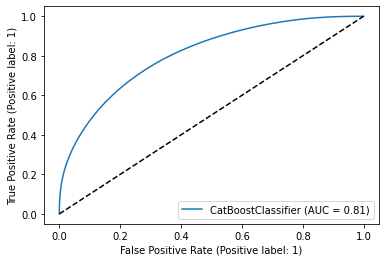

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

model = "xl3n4thc_CatBoostClassifier_default.cbm:v9"
model_name = model.split("/")[-1].split(":")[0]
    
artifact = run.use_artifact(model)
model_dir = artifact.download()
    
clf = CatBoostClassifier()
clf.load_model(fname=Path(model_dir, model_name))

RocCurveDisplay.from_estimator(
clf, X_test, y_test, response_method="predict_proba")

plt.plot([0, 1], [0, 1], 'k--', label="random")

plt.show()

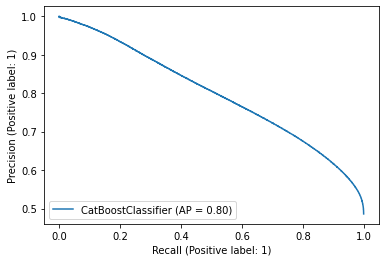

In [18]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_estimator(clf, X_test, y_test, pos_label=clf.classes_[1])
plt.show()

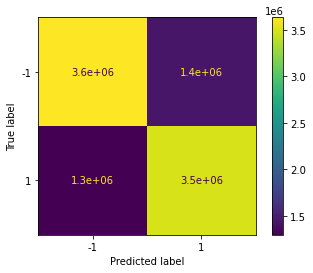

In [12]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)
plt.show()

In [10]:
results = []

feature_map = {"classical": features_classical, "classical-size": features_classical_size, "ml": features_ml}

for feature_str, model in tqdm(models):

    model_name = model.split("/")[-1].split(":")[0]
    
    artifact = run.use_artifact(model)
    model_dir = artifact.download()
    
    model = CatBoostClassifier()
    model.load_model(fname=Path(model_dir, model_name))
    
    fs = feature_map.get(feature_str)
    
    result = model.predict(X_test.loc[:,fs])
    results.append(result)

  0%|          | 0/3 [00:00<?, ?it/s]

wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  


In [11]:
# results = pd.DataFrame(dict(zip([f[0] for f in models], results)), index=X_test.index)
output_path = f"gs://thesis-bucket-option-trade-classification/data/results/{key}.parquet"
results.to_parquet(output_path)

# Log the artifact to save it as an output of this run
result_set = wandb.Artifact(name=key, type="results")
result_set.add_reference(output_path, name="results")
run.log_artifact(result_set)

wandb.finish()